In [754]:
using NBInclude
using LinearAlgebra

In [30]:
@nbinclude("julia_function.ipynb")

allskyts2 (generic function with 1 method)

<h1>Reconstructing the neutrino galaxy with pseudo-Dirac neutrinos</h1>

Consider some LOS bin $\vec{\Theta}$. At some energy $E_i$, we can calculate the number of neutrinos at Earth at that energy by the following (for a detector with perfect angular and energy resolution):
$$
N_{\nu}(E_i, \vec{\Theta}) = \int_{\vec{\Theta}}d\theta~\int_{E_i}^{E_{i+1}} dE~\int_0^{\infty} dr~ \Phi (r, \vec{\Theta}, E) A_{\mathrm{eff}}(E) O(r, E),
$$
where:

$A_{\mathrm{eff}}$ is the detector's effective area, 

$\Phi$ is the neutrino flux at the source, and

$O$ is the probability that the neutrino oscillates into an electorn neutrino at Earth (also a function of $\delta m ^2$).

We can approximate this expression by discretizing the integral, further approximating by evaluating the energy terms at the left edge of the bin:
$$
N_{\nu}(E_i, \vec{\Theta}) \approx \sum_{j=1}^{n} \Phi (r_j, \vec{\Theta}, E_i) A_{\mathrm{eff}}(E_i) O(r_j, E_i) B(r_j, \vec{\Theta}) \Delta r \Delta E,
$$
where $B$ is the volume of the $r_j$ spatial bin.

What if we assume that the energy and spatial neutrino distributions are independent? i.e.
$$
\Phi (r, \vec{\Theta}, E) = \Phi_0 \left(\frac{E}{E_0}\right)^{-\gamma}P_{\nu}(r, \vec{\Theta}),
$$
where $P_{\nu}$ is the neutrino spatial probability density distribution. We can thus bring every term not dependent on $r$ outside the sum, getting
$$
N_{\nu}(E_i, \vec{\Theta}) \approx c(E_i) \sum_{j=1}^{n} O(r_j, E_i) B(r_j, \vec{\Theta}) P_{\nu}(r_j, \vec{\Theta}),
$$
where
$$
c(E) = \Phi_0 \left(\frac{E}{E_0}\right)^{-\gamma} A_{\mathrm{eff}}(E) \Delta r \Delta E.
$$
For LOS angle bin $\vec{\Theta}$ and bin $(E_i, r_j)$, let

$\nu_{i} = N_{\nu}(E_i, \vec{\Theta})$, $~c_i = c(E_i)$, $~p_j = P_{\nu}(r_j, \vec{\Theta})$,  and $~o_{ij} = O(r_j, E_i) B(r_j, \vec{\Theta})$.

Then for $m$ energy bins and $n$ spatial bins, we get the following matrix:
$$
\begin{pmatrix} \nu_1 \\ \nu_2 \\ \vdots \\ \nu_m \end{pmatrix}
=
\begin{pmatrix}
    c_1 o_{11} & c_1 o_{12} & \dots & c_1 o_{1n} \\
    c_2 o_{21} & c_2 o_{22} & \dots & c_2 o_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    c_m o_{m1} & c_m o_{m2} & \dots & c_m o_{mn}
\end{pmatrix}
\begin{pmatrix} p_1 \\ p_2 \\ \vdots \\ p_n \end{pmatrix}
$$
Solving this matrix, we should be able to obtain binned $P_{\nu}$ for each LOS bin.

Let's first plot the perfect energy distributions and oscillation probabilities:

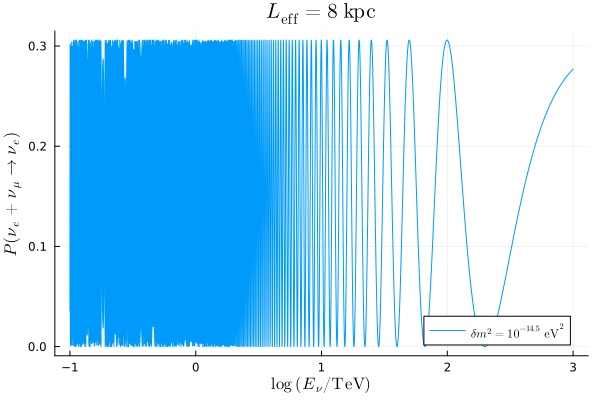

In [570]:
# Plotting oscillation probabilities

logesample = range(-1, 3, 10000)
esample = 10 .^ logesample

plot(
    logesample,
    [oscprob.(esample, 10^(-12), 8)],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{e} + \nu_{\mu} \to \nu_{e})",
    label=[L"\delta m^2 = 10^{-14.5}~\mathrm{eV}^2" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2" L"\delta m^2 = 10^{-13.5}~\mathrm{eV}^2"],
    title=L"L_{\mathrm{eff}} = 8~\mathrm{kpc}"
)

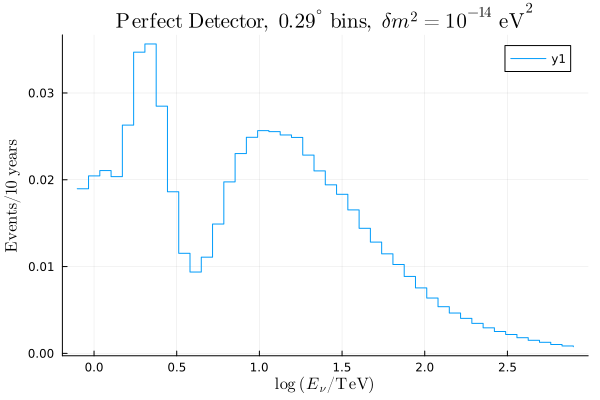

attempt to save state beyond implementation limit


In [706]:
# Plotting perfect event distributions

us = range(log10(emin), log10(emax), 45)
plot(
    us,
    # [ebinstrue(dm2, 0, 0, 0.122, 21.8, 2.7, 50, 0.5) ebinstrueapprox(dm2, 0, 0, 0.122, 21.8, 2.7, 50, 0.5)],
    perfectedist(10^(-14), 0, 0, 21.8, 2.7, 0.005, 45),
    seriestype=:step,
    title=L"\mathrm{Perfect~Detector},~0.29^{\circ}~\mathrm{bins},~\delta m^2 = 10^{-14}~\mathrm{eV}^2",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events} / 10~\mathrm{years}"
)

<h1>Defining functions</h1>

In [969]:
function c(u, du, dr)
    e = 10^u
    effarea(e) * 10000 * flx(e) * du * dr * 10^u * log(10) * 3
end

function o(dm2, u, r, dr, l, b, θ)
    e = 10^u
    oscprob(e, dm2, r) * sbinarea.((r+dr), l, b, θ)
end

function matvals(dm2, us, rs, i, j, du, dr, l, b, θ)
    ui = us[i]
    rj = rs[j]
    c(ui, du, dr) * o(dm2, ui, rj, dr, l, b, θ)
end

function perfectedist(dm2, l, b, ϕ₀, γ, θ, nsteps)
    
    function f(u)
        et = 10 ^ u
        r0, rmax = 0, 30
        rbins = range(r0, rmax, nsteps)
        dr = rbins[2] - rbins[1]

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    # du = (log10(emax) - log10(emin)) / nsteps
    us = range(log10(emin), log10(emax), nsteps)

    du = us[2] - us[1]

    output = f.(us) .* du .* (10 .^ us) .* log(10)
end

function pdreconstruct(dm2, l, b, bins)

    us = range(log10(emin), log10(emax), bins)
    rs = range(0, 30, bins)

    du = us[2] - us[1]
    dr = rs[2] - rs[1]

    A = [matvals(dm2, us, rs, i, j, du, dr, l, b, 0.005) for i in 1:bins, j in 1:bins]

    #function perfectedist(dm2, l, b, ϕ₀, γ, θ, nsteps, dr)
    eventsvec = perfectedist(dm2, l, b, 21.8, 2.7, 0.005, bins)

    sol = A \ eventsvec

end

pdreconstruct (generic function with 1 method)

In [979]:
perfectedist(10^(-14), 0, 0, 21.8, 2.7, 0.005, 5)

5-element Vector{Float64}:
 0.05402918293551841
 0.05156925878217221
 0.10012214439317776
 0.023887134834221824
 0.003947734655535919

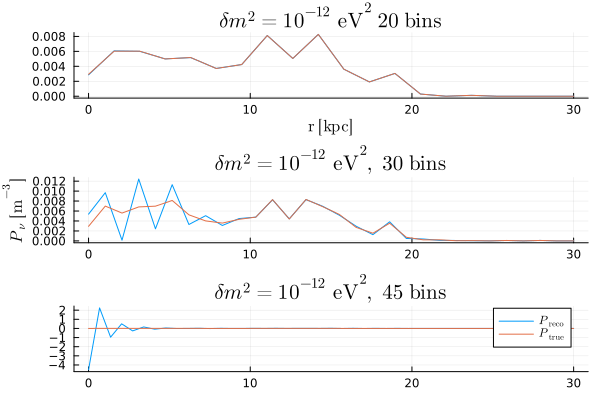

In [983]:
rbins10 = range(0, 30, 10)
rbins20 = range(0, 30, 20)
rbins30 = range(0, 30, 30)
rbins45 = range(0, 30, 45)
rbins80 = range(0, 30, 80)


pds10 = probdens.(cartx.(rbins10, 0, 0), carty.(rbins10, 0, 0), cartz.(rbins10, 0, 0))
pds20 = probdens.(cartx.(rbins20, 0, 0), carty.(rbins20, 0, 0), cartz.(rbins20, 0, 0))
pds30 = probdens.(cartx.(rbins30, 0, 0), carty.(rbins30, 0, 0), cartz.(rbins30, 0, 0))
pds45 = probdens.(cartx.(rbins45, 0, 0), carty.(rbins45, 0, 0), cartz.(rbins45, 0, 0))
pds80 = probdens.(cartx.(rbins80, 0, 0), carty.(rbins80, 0, 0), cartz.(rbins80, 0, 0))


p30bins = plot(
    rbins45,
    [pdreconstruct(10^(-12), 0, 0, 45) pds45],
    label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    title=L"\delta m^2 = 10^{-12}~\mathrm{eV}^2,~45~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    # xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)

p45bins = plot(
    rbins30,
    [pdreconstruct(10^(-12), 0, 0, 30) pds30],
    # label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    label=false,
    title=L"\delta m^2 = 10^{-12}~\mathrm{eV}^2,~30~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    # xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)

p50bins = plot(
    rbins20,
    [pdreconstruct(10^(-12), 0, 0, 20) pds20],
    # label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    label=false,
    title=L"\delta m^2 = 10^{-12}~\mathrm{eV}^2~20~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)



plot(p50bins, p45bins, p30bins, layout=(3, 1))

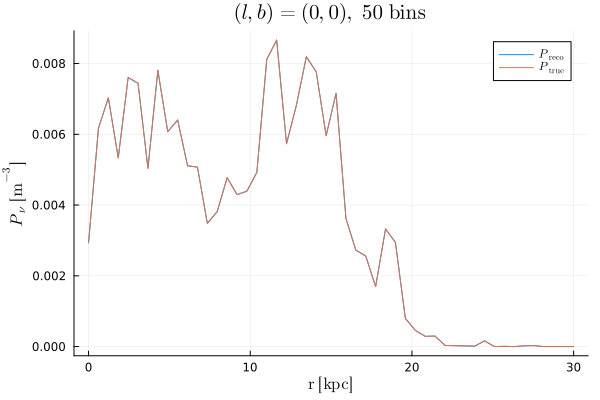

In [940]:
rbins60 = range(0, 30, 50)
pds60 = probdens.(cartx.(rbins60, 0, 0), carty.(rbins60, 0, 0), cartz.(rbins60, 0, 0))
p60bins = plot(
    rbins60,
    [pdreconstruct(10^(-5), 0, 0, 50) pds60],
    label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    title=L"(l, b) = (0, 0),~50~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)

In [966]:
function c(u, du, dr)
    e = 10^u
    effarea(e) * 10000 * flx(e) * du * dr * 10^u * log(10) * 3
end

function o(dm2, u, r, dr, l, b, θ)
    e = 10^u
    oscprob(e, dm2, r) * sbinarea.((r+dr), l, b, θ)
end

function matvals(dm2, us, rs, i, j, du, dr, l, b, θ)
    ui = us[i]
    rj = rs[j]
    c(ui, du, dr) * o(dm2, ui, rj, dr, l, b, θ)
end

matvals (generic function with 4 methods)

In [971]:
function matrixA(dm2, l, b, bins)  

    # du = (log10(emax) - log10(emin)) / bins

    us = range(log10(emin), log10(emax), bins)

    # dr = 30 / bins
    rs = range(0, 30, bins)

    du = us[2] - us[1]
    dr = rs[2] - rs[1]

    A = [matvals(dm2, us, rs, i, j, du, dr, l, b, 0.005) for i in 1:bins, j in 1:bins]

    #function perfectedist(dm2, l, b, ϕ₀, γ, θ, nsteps, dr)
    # eventsvec = perfectedist(dm2, l, b, 21.8, 2.7, 0.005, bins)

    # sol = A \ eventsvec
end

matrixA (generic function with 1 method)

In [974]:
bins = 10

us = range(log10(emin), log10(emax), bins)

rs = range(0, 30, bins)

du = us[2] - us[1]
dr = rs[2] - rs[1]

c.(us, du, dr)
o.(10^(-14), us, rs, dr, 0, 0, 0.005)

10-element Vector{Float64}:
 8.499037923831634e-5
 0.00017722273039818946
 0.0004404273301874042
 0.001054291545980553
 0.001932382641912571
 0.002964444888853545
 0.00412403272433082
 0.005423838224330975
 0.006878680334056672
 0.008497172497903088

In [975]:
matrixA(10^(-14), 0, 0, 5)

5×5 Matrix{Float64}:
 2.24906    6.43912    3.76904    0.483249  22.1462
 3.3613     8.40845    1.90246    8.35644   64.2234
 1.30167    5.13558   11.0838    18.3594    25.9064
 0.296451   1.18529    2.66343    4.72472    7.35995
 0.0489217  0.195684   0.440271   0.782651   1.22277

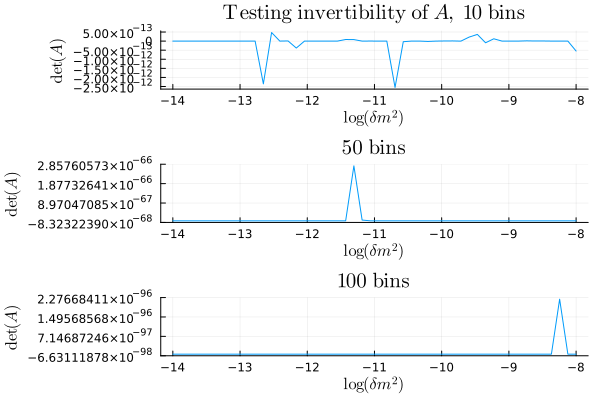

In [872]:
# Showing the invertibility of our matrices

function detmat(dm2, l, b, bins)

    det(matrixA(dm2, l, b, bins))

end

logdm2s = range(-14.0, -8.0, 50)
dm2s = 10 .^ logdm2s

p10bins = plot(
    logdm2s,
    detmat.(dm2s, 0, 0, 10),
    title=L"\mathrm{Testing~invertibility~of~}A,~10~\mathrm{bins}",
    ylabel=L"\det(A)",
    xlabel=L"\log (\delta m^2)",
    label=false
)

p50bins = plot(
    logdm2s,
    detmat.(dm2s, 0, 0, 50),
    title=L"50~\mathrm{bins}",
    ylabel=L"\det(A)",
    xlabel=L"\log (\delta m^2)",
    label=false
)

p100bins = plot(
    logdm2s,
    detmat.(dm2s, 0, 0, 100),
    title=L"100~\mathrm{bins}",
    ylabel=L"\det(A)",
    xlabel=L"\log (\delta m^2)",
    label=false
)

plot(p10bins, p50bins, p100bins, layout=(3, 1))

In [980]:
sebinss = 2:2:100

logdm2s = range(-20.0, -7.0, 50)
dm2s = 10 .^ logdm2s

function invtest(dm2, sebins)
    mat = matrixA(dm2, 0, 0, sebins)
    id = I(sebins)
    should_be_id = inv(mat) * mat
    diff = norm(id - should_be_id)
end

function pinvtest(dm2, sebins)
    mat = matrixA(dm2, 0, 0, sebins)
    id = I(sebins)
    should_be_id = pinv(mat) * mat
    diff = norm(id - should_be_id)
end

function logdet(dm2, sebins)

    deta = det(matrixA(dm2, 0, 0, sebins))
    logabsdeta = log10(abs(deta))

end

function recoaccuracy(dm2, sebins)

    rbins = range(0, 30, sebins)

    pdtrue = probdens.(cartx.(rbins, 0, 0), carty.(rbins, 0, 0), cartz.(rbins, 0, 0))

    pdrec = pdreconstruct(dm2, 0, 0, sebins)

    acc = norm(pdrec .- pdtrue)

end

function pdreconstruct1(dm2, l, b, bins)

    us = range(log10(emin), log10(emax), bins)

    # dr = 30 / bins
    rs = range(0, 30, bins)

    A = [matvals(dm2, us, rs, i, j, du, dr, l, b, 0.005) for i in 1:bins, j in 1:bins]

    #function perfectedist(dm2, l, b, ϕ₀, γ, θ, nsteps, dr)
    eventsvec = perfectedist(dm2, l, b, 21.8, 2.7, 0.005, bins)

    sol = pinv(A) * eventsvec

end

function reco1accuracy(dm2, sebins)

    rbins = range(0, 30, sebins)

    pdtrue = probdens.(cartx.(rbins, 0, 0), carty.(rbins, 0, 0), cartz.(rbins, 0, 0))

    pdrec = pdreconstruct1(dm2, 0, 0, sebins)

    acc = norm(pdrec .- pdtrue)

end

invtestmat = [reco1accuracy(dm2, bins) for dm2 in dm2s, bins in sebinss]

InterruptException: InterruptException:

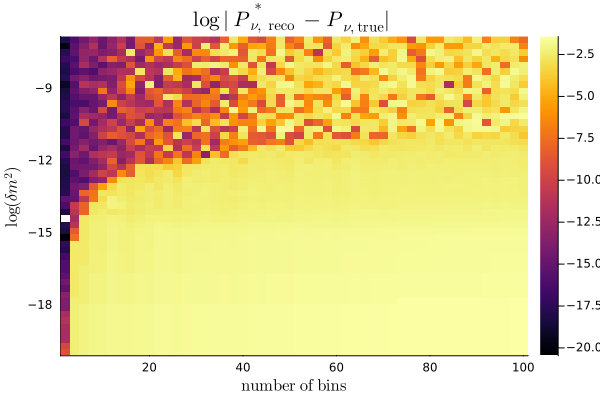

In [922]:
heatmap(
    sebinss,
    logdm2s,
    log10.(invtestmat),
    title=L"\log~\| P_{\nu,~\mathrm{reco}}^* - P_{\nu, \mathrm{true}} \|",
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log (\delta m^2)",
    color=:inferno
)

In [845]:
invtest(10^(-8), 20)

0.010692685128685417

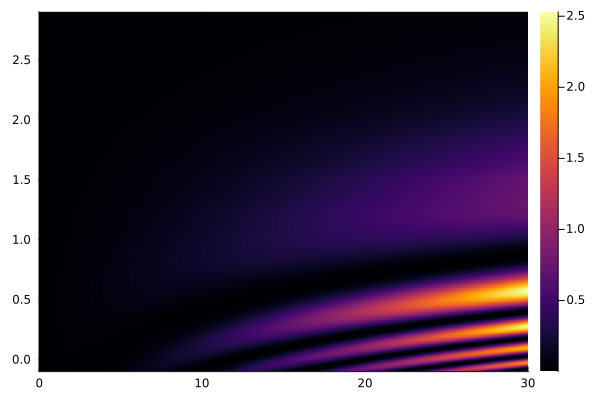

In [739]:
# Amat = reshape(A, length(us), length(rs))

heatmap(
    rs,
    us,
    A
)

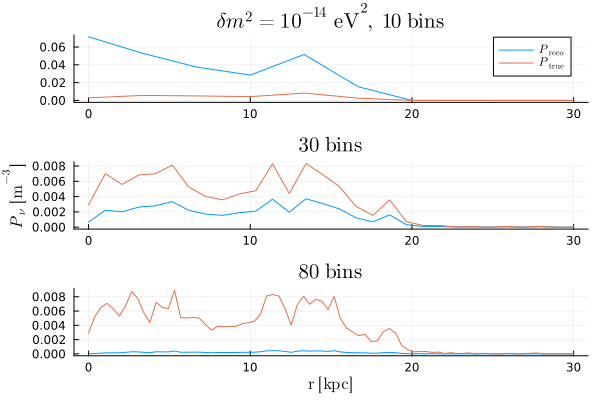

In [941]:
rbins10 = range(0, 30, 10)
rbins20 = range(0, 30, 20)
rbins30 = range(0, 30, 30)
rbins45 = range(0, 30, 45)
rbins80 = range(0, 30, 80)


pds10 = probdens.(cartx.(rbins10, 0, 0), carty.(rbins10, 0, 0), cartz.(rbins10, 0, 0))
pds20 = probdens.(cartx.(rbins20, 0, 0), carty.(rbins20, 0, 0), cartz.(rbins20, 0, 0))
pds30 = probdens.(cartx.(rbins30, 0, 0), carty.(rbins30, 0, 0), cartz.(rbins30, 0, 0))
pds45 = probdens.(cartx.(rbins45, 0, 0), carty.(rbins45, 0, 0), cartz.(rbins45, 0, 0))
pds80 = probdens.(cartx.(rbins80, 0, 0), carty.(rbins80, 0, 0), cartz.(rbins80, 0, 0))


p30bins = plot(
    rbins10,
    [pdreconstruct1(10^(-7), 0, 0, 10) pds10],
    label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    title=L"\delta m^2 = 10^{-14}~\mathrm{eV}^2,~10~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    # xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)

p45bins = plot(
    rbins30,
    [pdreconstruct1(10^(-7), 0, 0, 30) pds30],
    # label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    label=false,
    title=L"30~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    # xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)

p50bins = plot(
    rbins80,
    [pdreconstruct1(10^(-7), 0, 0, 80) pds80],
    # label=[L"P_{\mathrm{reco}}" L"P_{\mathrm{true}}"],
    label=false,
    title=L"80~\mathrm{bins}",
    #\mathrm{Reconstructed}~\nu~\mathrm{spatial~distribution},~
    xlabel=L"\mathrm{r}~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]"
)



plot(p30bins, p45bins, p50bins, layout=(3, 1))

In [927]:
function perfectbinnededist(dm2, l, b, ϕ₀, γ, θ, nbins)
    
    function f(u)
        et = 10 ^ u
        r0, rmax = 0, 30
        rbins = range(r0, rmax, nsteps)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    # du = (log10(emax) - log10(emin)) / nsteps
    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function pdreconstruct2(dm2, l, b, bins)

    us = range(log10(emin), log10(emax), bins)

    # dr = 30 / bins
    rs = range(0, 30, bins)

    A = [matvals(dm2, us, rs, i, j, du, dr, l, b, 0.005) for i in 1:bins, j in 1:bins]

    #function perfectedist(dm2, l, b, ϕ₀, γ, θ, nsteps, dr)
    eventsvec = perfectbinnededist(dm2, l, b, 21.8, 2.7, 0.005, bins)

    sol = pinv(A) * eventsvec

end

pdreconstruct2 (generic function with 1 method)

In [928]:
# pdreconstruct2(10^(-14), 0, 0, 50)

perfectbinnededist(10^(-14), 0, 0, 21.8, 2.7, 0.005, 50)

50-element Vector{Float64}:
  8.954357374593116
  9.290129966098977
  9.379680771306296
  9.364384382407156
 11.53151087668711
 14.753948390747583
 16.053389828184375
 14.296983900189993
 10.582835868257217
  6.98233884415011
  ⋮
  1.2105504124369955
  1.0607478908052732
  0.9248195494571937
  0.7809885322374887
  0.6668485799422859
  0.5756437382290714
  0.47779533047839534
  0.39999003880151085
  0.3598878806358742